In [34]:
import pandas as pd
import numpy as np
import os
import scipy
import itertools
import seaborn as sns
import matplotlib.pyplot as plt    
import xgboost as xgb
iv=['np'    , 'os'     ,'pd'    , 'plt'     ,'tqdm'    , 'train'     ,'train_date'      , 'train_num' ,'data'    ]
def memchk(iv):
    import sys,operator
    ipython_vars=iv
    ,'warnings'    , 'xgboost']
    print sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
    return sorted([{i:sys.getsizeof(globals().get(i))/1000000.0} for i in ipython_vars])
%matplotlib inline
from sklearn.metrics import confusion_matrix
import warnings
%load_ext autotime
warnings.filterwarnings('ignore')
from tqdm import tqdm
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
plt.style.use('classic')
from contigency import Ttable,table, plot 

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 884 ms


In [35]:
data = pd.read_csv(r'C:\Users\sushant\Documents\Datasets\NYC\data_clean.csv')#.drop('Unnamed: 0',1)

time: 27.8 s


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083778 entries, 0 to 2083777
Data columns (total 23 columns):
dropoff_datetime         object
dropoff_latitude         float64
dropoff_longitude        float64
id                       object
passenger_count          int64
pickup_datetime          object
pickup_latitude          float64
pickup_longitude         float64
store_and_fwd_flag       object
trip_duration            float64
vendor_id                int64
dropoff_datetimeyear     float64
dropoff_datetimemonth    float64
dropoff_datetimeday      float64
dropoff_datetimehour     float64
dropoff_datetimedate     object
pickup_datetimeyear      int64
pickup_datetimemonth     int64
pickup_datetimeday       int64
pickup_datetimehour      int64
pickup_datetimedate      object
Train                    int64
Valid                    int64
dtypes: float64(9), int64(8), object(6)
memory usage: 365.7+ MB
time: 41 ms


### Haversine distance

In [37]:
from haversine import haversine
data['distance']=data[['pickup_latitude',	'pickup_longitude','dropoff_latitude',	'dropoff_longitude']].apply(lambda l:haversine((l['pickup_latitude'],l['pickup_longitude']),(l['dropoff_latitude'],l['dropoff_longitude'])),axis=1)

time: 2min 5s


In [38]:
print 'Categorical'
cat_var= data.select_dtypes(include = ['object']).columns.values.tolist()
print cat_var
print '\nNumerical Variables'
num_var = data.select_dtypes(include = ['int64','float64']).columns.values.tolist()
print num_var

Categorical
['dropoff_datetime', 'id', 'pickup_datetime', 'store_and_fwd_flag', 'dropoff_datetimedate', 'pickup_datetimedate']

Numerical Variables
['dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'pickup_latitude', 'pickup_longitude', 'trip_duration', 'vendor_id', 'dropoff_datetimeyear', 'dropoff_datetimemonth', 'dropoff_datetimeday', 'dropoff_datetimehour', 'pickup_datetimeyear', 'pickup_datetimemonth', 'pickup_datetimeday', 'pickup_datetimehour', 'Train', 'Valid', 'distance']
time: 9.17 s


AxesImage(72,43.2;372x372)


## Train

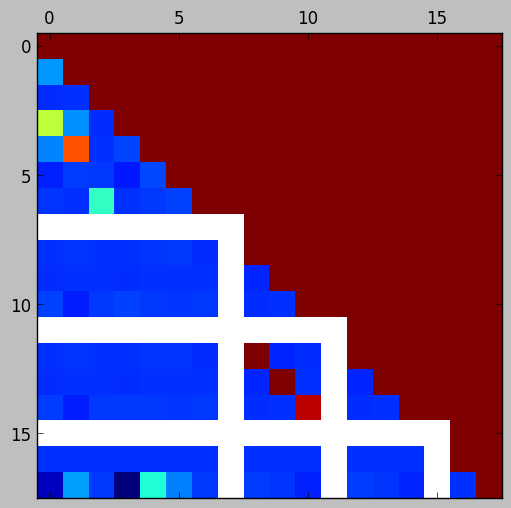

time: 18.3 s


In [39]:
def corrlist(data):
    feat=data.columns.tolist()
    corrmat=np.array(data.corr())
    for i in range(len(corrmat)):
        for j in range(len(corrmat)):
            if j>i :
                corrmat[i][j]=1
    corrFrame= pd.DataFrame(pd.DataFrame(corrmat,columns=feat,index=feat).unstack()).reset_index()
    print plt.matshow(corrmat)
    del corrmat
    corrFrame=corrFrame[corrFrame[0]<1].rename(columns={0:'corr'})
    return corrFrame

corrdata=corrlist(data[num_var][data['Train']==1])
printmd('## Train')

# Draw a heatmap with the numeric values in each cell
#sns.heatmap(pdata, annot=True,  linewidths=.5)

AxesImage(72,43.2;372x372)


## Test

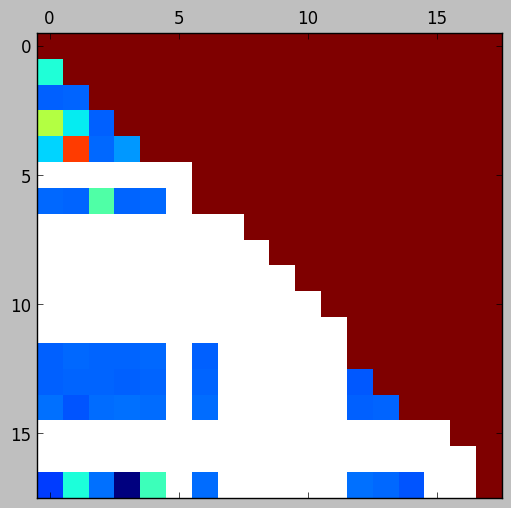

time: 1.38 s


In [40]:
corrdata2=corrlist(data[num_var][data['Train']==0])
printmd('## Test')

In [41]:
corrdata[corrdata['level_0']=='trip_duration']

,level_0,level_1,corr
96,trip_duration,vendor_id,0.020304
98,trip_duration,dropoff_datetimemonth,0.007512
99,trip_duration,dropoff_datetimeday,0.002366
100,trip_duration,dropoff_datetimehour,0.002652
102,trip_duration,pickup_datetimemonth,0.006607
103,trip_duration,pickup_datetimeday,0.000566
104,trip_duration,pickup_datetimehour,0.003690
106,trip_duration,Valid,-0.000985
107,trip_duration,distance,0.094777


time: 2.4 s


In [42]:
corrdata=corrdata[(corrdata['corr']>0.1)|(corrdata['corr']<-0.1)]
corrdata2=corrdata2[(corrdata2['corr']>0.1)|(corrdata2['corr']<-0.1)]

time: 10 ms


## Train

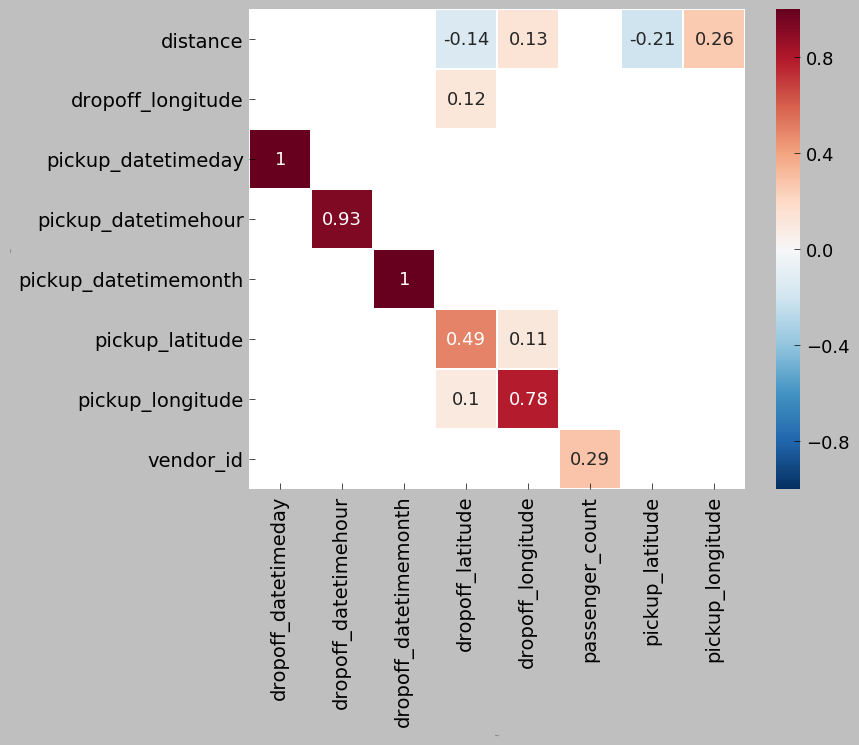

time: 5.92 s


In [43]:
# Draw a heatmap with the numeric values in each cell
printmd('## Train')
plt.rc('font', size=13)
fig = plt.figure(figsize=(8, 6))
pdata = corrdata.pivot("level_1", "level_0", "corr")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('xlabel', fontsize=0)
plt.ylabel('ylabel', fontsize=0)
sns.heatmap(pdata, annot=True,  linewidths=.5)


## Test

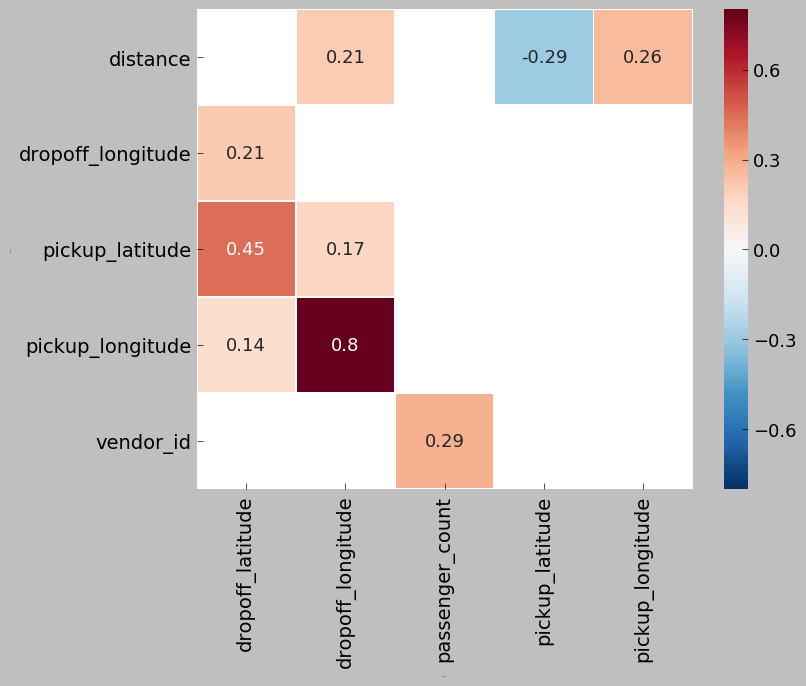

time: 901 ms


In [44]:
printmd('## Test')
plt.rc('font', size=13)
fig = plt.figure(figsize=(8, 6))
pdata = corrdata2.pivot("level_1", "level_0", "corr")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('xlabel', fontsize=0)
plt.ylabel('ylabel', fontsize=0)
sns.heatmap(pdata, annot=True,  linewidths=.5)

In [45]:
len(data[data['trip_duration']<200000])

1458640

time: 407 ms


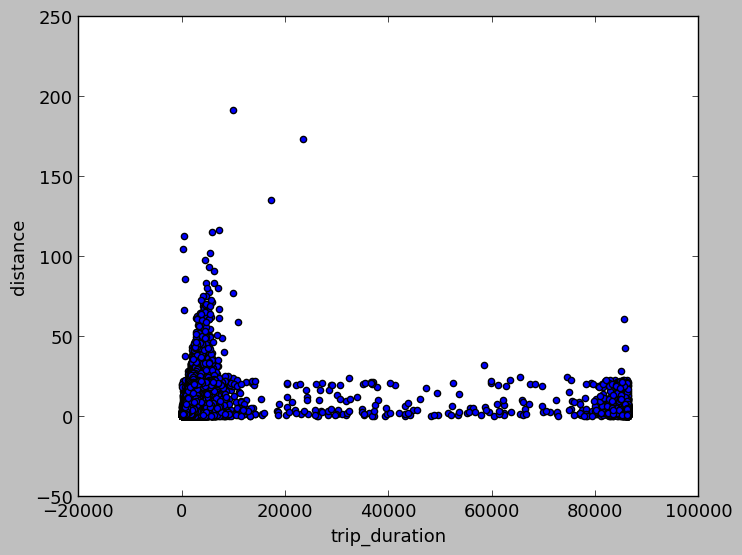

time: 35.1 s


In [46]:
data[(data['Train']==1)&(data['trip_duration']<200000)&(data['distance']<200)].plot(x='trip_duration',y='distance',kind='scatter')

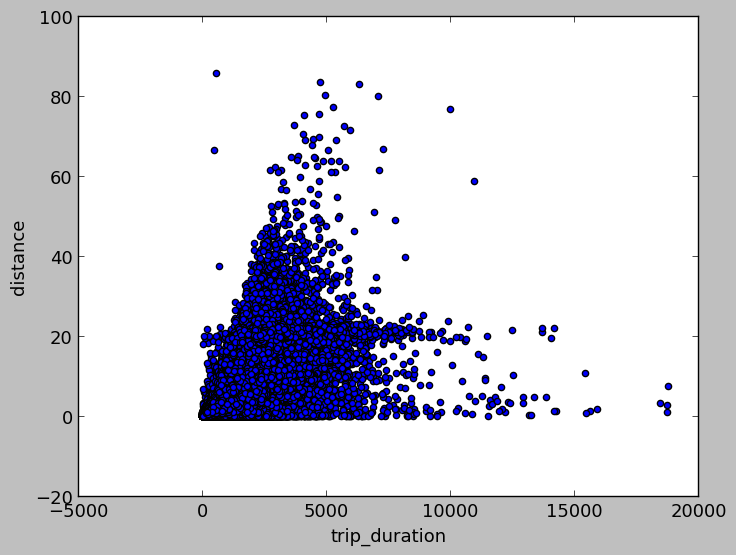

time: 29.2 s


In [47]:
data[(data['Train']==1)&(data['trip_duration']<20000)&(data['distance']<90)].plot(x='trip_duration',y='distance',kind='scatter')

In [48]:
data[(data['Train']==1)&(data['trip_duration']<20000)&(data['distance']<90)][['trip_duration','distance']].corr()

,trip_duration,distance
trip_duration,1.000000,0.764138
distance,0.764138,1.000000


time: 406 ms


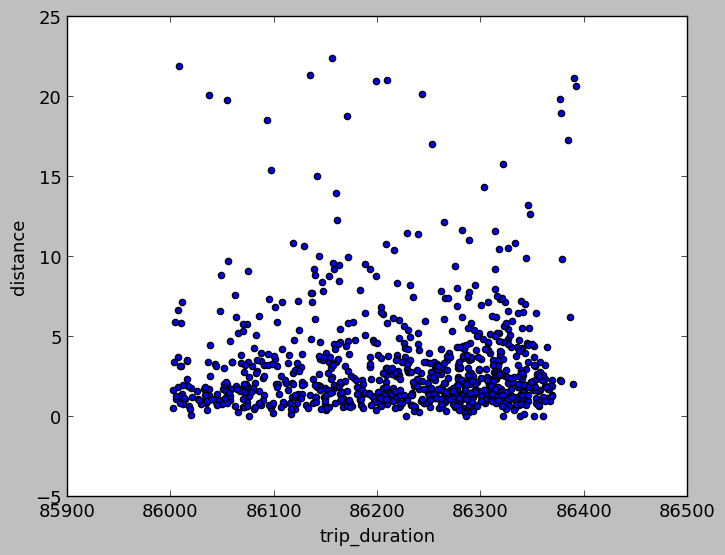

time: 651 ms


In [49]:
data[(data['Train']==1)&(data['trip_duration']>86000)&(data['distance']<90)&(data['trip_duration']<90000)].plot(x='trip_duration',y='distance',kind='scatter')

In [50]:
data[(data['Train']==1)&(data['trip_duration']>86000)&(data['distance']<90)&(data['trip_duration']<90000)][['trip_duration','distance']].corr()

,trip_duration,distance
trip_duration,1.000000,0.015289
distance,0.015289,1.000000


time: 46 ms


In [51]:
#data['magic_flag']=0

#data['magic_flag'][((data['Train']==1)&(data['trip_duration']<20000)&(data['distance']<90))]=1

#data['magic_flag'].value_counts()

time: 188 ms


In [52]:
table(data.head(),'dropoff_datetimehour','pickup_datetimehour')

pickup_datetimehour,0,11,13,17,19
dropoff_datetimehour,,,,,
0.0,1.0,NaN,NaN,NaN,NaN
12.0,NaN,1.0,NaN,NaN,NaN
13.0,NaN,NaN,1.0,NaN,NaN
17.0,NaN,NaN,NaN,1.0,NaN
19.0,NaN,NaN,NaN,NaN,1.0


time: 15.3 s


In [54]:
data.to_csv(r'C:\Users\sushant\Documents\Datasets\NYC\data_clean_eda.csv',index=False)

time: 37.3 s
